In [3]:
# Load packages
import os 
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import gridspec
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
from math import sqrt
import string

# Parameters
_figsize = (20,5)
_days_per_year = 252.0
_initial_cap = 100.0
_dec_positions = 4
_labels = ['(Strategy)', '(No Strategy)']
_colors = ['teal', 'slateblue']
_alpha = 0.8
_title_fontsize = 20
_ABC = list(string.ascii_uppercase)

# Date parser
dateparse = lambda dates: [pd.datetime.strptime(d, '%d/%m/%Y') for d in dates]

def scale(data):
    return (data - data.min()) * 1.0 / (data.max() - data.min())

def load_security_info(filename):
    raw_names = pd.read_csv(filename, skiprows=3, nrows=1)
    idx_names = ~raw_names.columns.str.contains('^Unnamed')
    security_names = raw_names.loc[:,idx_names].columns.tolist()
    security_idx_col = [raw_names.columns.get_loc(security_name)-1 for security_name in security_names]

    return security_names, security_idx_col

def load_timeserie_names(filename):
    timeserie_names = pd.read_csv(filename, skiprows=3, nrows=1).dropna(axis=1)
    
    return timeserie_names.values.flatten().tolist()

def load_security(filename):
    security_names, security_idx_col = load_security_info(filename)
    timeserie_names = load_timeserie_names(filename)

    security={}
    for sidx, _ in enumerate(security_idx_col):
        if sidx == (len(security_idx_col)-1):
            timeserie_idxs = range(security_idx_col[sidx], len(timeserie_names))
        else:
            timeserie_idxs = range(security_idx_col[sidx], security_idx_col[sidx+1])        

        security[sidx] = load_timeserie(filename, timeserie_idxs, timeserie_names)
    
    return security, security_names

def load_timeserie(filename, timeserie_idxs, timeserie_names):
    timeserie = {}
    for nidx, tidx in enumerate(timeserie_idxs):
        timeserie[nidx] = pd.read_csv(filename, skiprows=5, parse_dates=True, date_parser=dateparse, index_col='Dates', usecols=[0, tidx+1]).dropna()
        timeserie[nidx].columns = [timeserie_names[tidx]]
    
    return timeserie

def load_signal(filename):
    sheet_name = u'StrategyDetails'
    index_col = u'Date'
    usecols = [0, 3]
    
    return pd.read_excel(open(filename, 'rb'), parse_dates=True, index_col=index_col)

def process_security(signal, security):
    for fidx in security:
        security[fidx] = process_timeseries(signal, security[fidx])
    
    return security

def process_timeseries(signal, timeserie):
    for tidx in timeserie:
        timeserie[tidx] = process_timeserie_rows(signal, timeserie[tidx])
        #timeserie[tidx] = drop_rows(timeserie[tidx])
    return timeserie

def process_timeserie_rows(signal, timeserie):
    timeserie = get_pct_change(timeserie)
    timeserie = pd.concat([signal, timeserie],axis=1).dropna()
    
    for ridx in timeserie.index:
        if ridx == timeserie.index[0]:
            timeserie = initialize_timeserie_row(timeserie, ridx)
        else: 
            timeserie = update_timeserie_row(timeserie, ridx)    
    
    return timeserie
            
def initialize_timeserie_row(timeserie, ridx):
    for label in _labels:
        timeserie.loc[ridx, 'Total Return '+label] = _initial_cap 
        timeserie.loc[ridx, 'Total Return % '+label] = 0.0
        timeserie.loc[ridx, 'Drawdown '+label] = 0.0
    
    return timeserie

def update_timeserie_row(timeserie, ridx):
    prev_ridx = get_prev_idx(timeserie, ridx)
    for ignore_signal, label in enumerate(_labels):
        signal = timeserie.loc[ridx,'Exposure'] if not ignore_signal else 1
        timeserie.loc[ridx,'Total Return '+label] = get_total_return(signal, timeserie.loc[prev_ridx,'Total Return '+label], timeserie.loc[ridx,'% Change']) 
        timeserie.loc[ridx,'Daily Return % '+label] = get_daily_return_pct(timeserie.loc[ridx,'Total Return '+label], timeserie.loc[prev_ridx,'Total Return '+label])
        timeserie.loc[ridx,'Total Return % '+label] = get_total_return_pct(timeserie.loc[ridx,'Total Return '+label])
        timeserie.loc[ridx,'Drawdown '+label] = get_drawdown(timeserie['Total Return '+label].dropna())
    
    return timeserie

def drop_rows(timeserie):
    for label in _labels:
        timeserie = timeserie.drop(['Total Return '+label], axis=1)
        timeserie = timeserie.drop(['Daily Return % '+label], axis=1)
    
    return timeserie

def get_pct_change(df):
    for col_name in df.columns:
            df['% Change'] = df[col_name].pct_change().fillna(0)*100.0
    
    return df

def get_next_idx(df, idx):
    return df.index[df.index.get_loc(idx) + 1]

def get_prev_idx(df, idx):
    return df.index[df.index.get_loc(idx) - 1]

def process_summary(security):
    summary=[]
    for sidx in security:
        summary.append([])
        for tidx in security[sidx]:
            summary[sidx].append(initialize_summary())
            days_held = get_days_held(security[sidx][tidx])
            summary[sidx][tidx]['Total Return'] = get_total_cummulative_return(security[sidx][tidx])
            summary[sidx][tidx]['Annualized Total Return'] = get_annualized_return(summary[sidx][tidx]['Total Return'], days_held)
            summary[sidx][tidx]['Volatility'] = get_return_volatility(security[sidx][tidx], days_held)
            summary[sidx][tidx]['Annualized Volatility'] = get_annualized_volatility(summary[sidx][tidx]['Volatility'], days_held)
            summary[sidx][tidx]['Sharp Ratio'] = get_sharp_ratio(summary[sidx][tidx]['Total Return'], summary[sidx][tidx]['Volatility'])
            summary[sidx][tidx]['Annualized Sharp Ratio'] = get_sharp_ratio(summary[sidx][tidx]['Annualized Total Return'], summary[sidx][tidx]['Annualized Volatility'])
            summary[sidx][tidx]['Max Drawdown'] = get_max_drawdown(security[sidx][tidx][['Drawdown (Strategy)', 'Drawdown (No Strategy)']])
            summary[sidx][tidx] = summary[sidx][tidx].transpose()            
            
            security[sidx][tidx] = drop_rows(security[sidx][tidx])
    
    return summary

# Volatility = std(Total Return time series)
def get_return_volatility(timeserie, days_held):
    col_names = ['Daily Return % ' + label for label in _labels]
    volatility = []
    for col_name in col_names:
        volatility.append(timeserie[col_name].std() * sqrt(days_held))
    return volatility

def initialize_summary():
    return pd.DataFrame(index=['Strategy', 'No Strategy'])

def get_total_cummulative_return(timeserie):
    return [timeserie['Total Return % '+label].iat[-1] for label in _labels]

# Days Held = Final (Current) Date - Date of Inception
def get_days_held(df):
    return abs((df.last_valid_index() - df.first_valid_index()).days)

# Daily Return % = (Current Total Return / Previous Total Return - 1) * 100
def get_daily_return_pct(total_return, prev_total_return):
    return (total_return / prev_total_return - 1) *100.0

# Total Return % = (Cumulative Total Return / Initial Capital - 1) * 100
def get_total_return_pct(total_return):
    return (total_return / _initial_cap - 1) *100.0

# Total Return = Previous Total Return * (Signal * % Change of Price + 1)                    
def get_total_return(signal, prev_return, pct_change):                    
    return prev_return * (signal * pct_change/100.0 + 1)

# Drawdown = Current Value / Max(All Previous Values) - 1
def get_drawdown(df):
    return df.iloc[-1] / df.max() - 1.0

def get_max_drawdown(drawdowns):
    return drawdowns.min().tolist()

# Annualized Return = (1 + Total Return % ) ^ (365 / Days Held) - 1
def get_annualized_return(total_returns_pct, days_held):
    annualized_returns = []
    for total_return_pct in total_returns_pct.tolist():
        annualized_returns.append(((1 + total_return_pct / 100.0)**(_days_per_year / days_held) - 1) *100.0)
    return annualized_returns

# Annualized Volatility = Volatility * sqrt(Days per Year / Days Held)    
def get_annualized_volatility(vols, days_held):
    annualized_vols=[]
    for vol in vols:
        annualized_vols.append(vol * sqrt(_days_per_year/days_held))
    return annualized_vols

# Sharp Ratio = Total Return / Volatility
def get_sharp_ratio(total_return, volatility):
    return total_return/volatility

# Annualized Sharp Ratio = Total Return / Volatility
def get_annualized_sharp_ratio(annualized_total_return, annualized_volatility):
    return annualized_total_return/annualized_volatility

def plot_security(security, security_names):
    for sidx in security:    
        fig = plt.figure(figsize=(10, 10))
        gs = gridspec.GridSpec(3, 2)
        legend = []
        ax0 = plt.subplot(gs[0:1,:])
        for tidx in security[sidx]:
            legend.append(security[sidx][tidx].columns[1])
            line, = ax0.plot(security[sidx][tidx].iloc[:,1], _colors[tidx], alpha=_alpha)
            line.set_dashes([2, tidx])
        ax0.legend(legend)
        ax0.set_title(security_names[sidx], fontsize=_title_fontsize)

        plot_indicators(security[sidx], gs)
        
        plt.tight_layout()
        plt.savefig('./files/'+security_names[sidx]+'.png')
        plt.show()
        plt.close(fig)

def plot_indicators(security, gs):    
    indicators = ['Total Return % ', 'Drawdown ']
    for tidx in security:
        tname = security[tidx].columns[1]
        ax = []
        for iidx, indicator in enumerate(indicators):
            ax.append(plt.subplot(gs[1+iidx:2+iidx,tidx]))
            plot_indicator(security[tidx], tidx, indicator, ax[iidx])
        ax[0].set_title(tname, fontsize=15)

def plot_indicator(timeserie, tidx, indicator, ax):
    legend = []
    for ignore_signal, label in enumerate(_labels):
        color = _colors[tidx] if not ignore_signal else 'red'
        line, = ax.plot(timeserie[indicator+label], color, linewidth=1, alpha=_alpha)
        line.set_dashes([2, ignore_signal])
        legend.append(indicator+label)
    ax.legend(legend)
    
def write_output(security, security_names, summary):
    for sidx in security:
        security_output_file = './files/'+security_names[sidx]+'.xlsx'
        with pd.ExcelWriter(security_output_file, datetime_format='dd-mm-yyyy') as writer:
        
            # Output figures
            pd.DataFrame().to_excel(writer, sheet_name=security_names[sidx]+'-Figures')
            workbook = writer.book
            worksheet = writer.sheets[security_names[sidx]+'-Figures']
            worksheet.insert_image('A1', './files/'+security_names[sidx]+'.png')
            
            merge_format = workbook.add_format({'bold': 1, 'border': 1, 'align': 'center'})
            format1 = workbook.add_format({'num_format': '#,##0.0000'})
            
            for tidx in security[sidx]:
                startcol = 0
                startrow = 2 + (10*tidx)
                timeserie_name = security[sidx][tidx].columns[1]
                
                # Output summary
                sheet_name = security_names[sidx]+'-Summary'
                summary[sidx][tidx].to_excel(writer, sheet_name=sheet_name[:31], startrow=startrow)
                worksheet = writer.sheets[sheet_name[:31]]    
                range = make_excel_range([1,2], startrow)
                worksheet.merge_range(range, timeserie_name, merge_format)
                worksheet.set_column('A:C', 30, format1)
                
                # Output timeserie details
                sheet_name = security_names[sidx]+'-'+timeserie_name
                security[sidx][tidx].to_excel(writer, sheet_name=sheet_name[:31])
                
                worksheet = writer.sheets[sheet_name[:31]]
                worksheet.set_column('A:A', 15)
                for cidx, col in enumerate(security[sidx][tidx].columns):
                    worksheet.set_column(_ABC[cidx+1]+':'+_ABC[cidx+1], len(col), format1)
        
def make_excel_range(col, row):
    return _ABC[col[0]]+str(row)+':'+_ABC[col[1]]+str(row)


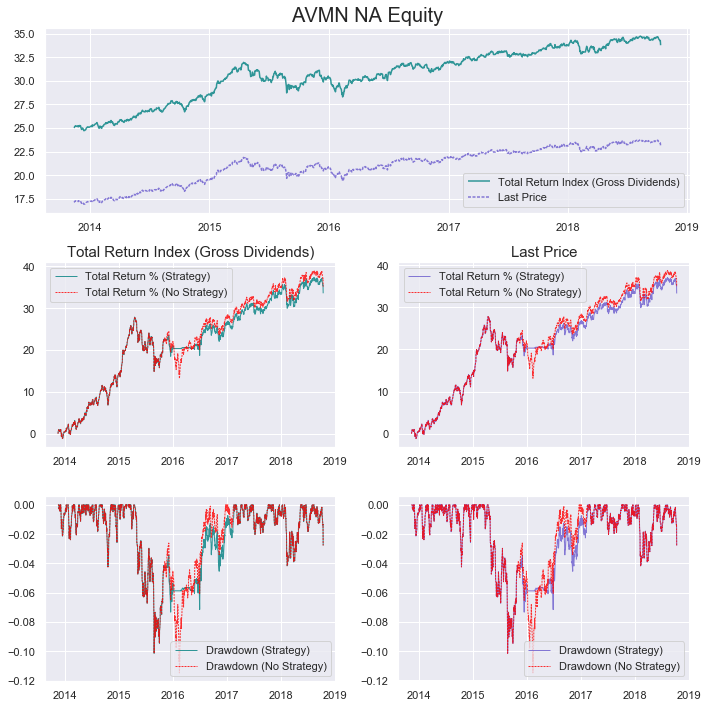

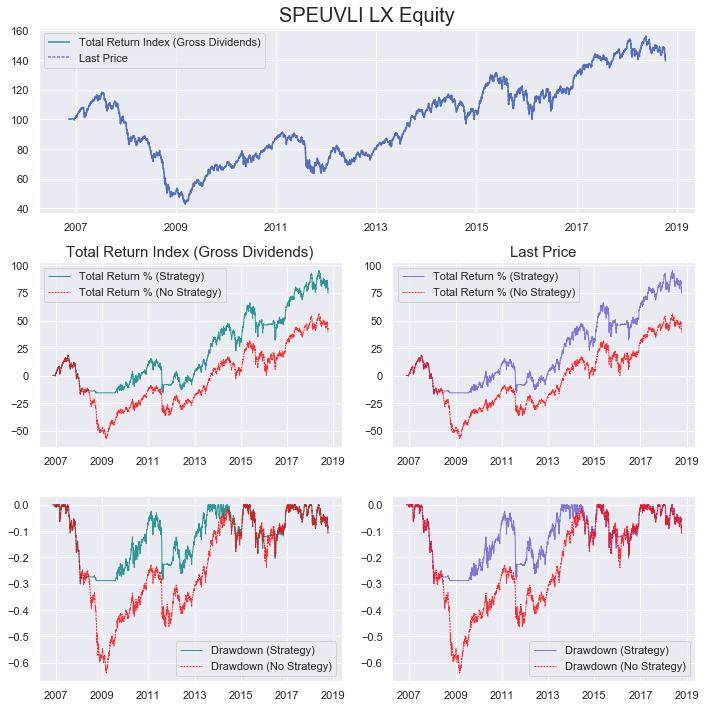

In [4]:
# Securities file
security_file = './files/securities.csv'
signal_file = './files/strategy_signal.xlsx'

# Load securities and signals
security, security_names = load_security(security_file)
signal = load_signal(signal_file)

# Process securities
security = process_security(signal, security)
summary = process_summary(security)

# Plot results
plot_security(security, security_names)

# Write output
write_output(security, security_names, summary)


## RESULTS
A comparison between the signal strategy and no strategy are presented for each security

### AVMA NA Equity
##### Total Return Index (Gross Dividends)

In [5]:
summary[0][0]

,Strategy,No Strategy
Total Return,33.518526,35.104000
Annualized Total Return,4.146441,4.319373
Volatility,16.584582,17.871718
Annualized Volatility,6.217484,6.700025
Sharp Ratio,2.021065,1.964221
Annualized Sharp Ratio,0.666900,0.644680
Max Drawdown,-0.101439,-0.114800


##### Last Price

In [6]:
summary[0][1]

,Strategy,No Strategy
Total Return,33.305897,34.907646
Annualized Total Return,4.123114,4.298051
Volatility,16.590968,17.877688
Annualized Volatility,6.219878,6.702263
Sharp Ratio,2.007472,1.952582
Annualized Sharp Ratio,0.662893,0.641284
Max Drawdown,-0.101413,-0.114810


### SPEUVLI LX Equity
##### Total Return Index (Gross Dividends)

In [7]:
summary[1][0]

,Strategy,No Strategy
Total Return,74.240156,39.146085
Annualized Total Return,3.264424,1.929519
Volatility,53.562294,68.670427
Annualized Volatility,12.882955,16.516806
Sharp Ratio,1.386053,0.570057
Annualized Sharp Ratio,0.253391,0.116822
Max Drawdown,-0.299882,-0.638758


##### Last Price

In [8]:
summary[1][1]

,Strategy,No Strategy
Total Return,74.240156,39.146085
Annualized Total Return,3.264424,1.929519
Volatility,53.562294,68.670427
Annualized Volatility,12.882955,16.516806
Sharp Ratio,1.386053,0.570057
Annualized Sharp Ratio,0.253391,0.116822
Max Drawdown,-0.299882,-0.638758
